# Notes on Torchgeo CloudRasterDataset class



### Populate dataset index

Dataset may not exist locally, in which case the index will be generated from
the tiles file provided. This class will be responsible for fetching rasters from the cloud service. Once images are fetched, the index will be populated with the bounds of each tile in the same way the torchgeo RasterDataset class works.

torchgeo `__init__` steps:
1. Loop over files in paths
2. Parse filenames to match regex
3. Extract metadata using rasterio - use WarpedVRT to reproject to user selected crs
4. Add bounds (minx, maxx, miny maxy, mint, maxt) and metadata to index
Raises error if paths is empty

In [1]:
import geopandas as gpd
import ee
from torchgeo.datasets import BoundingBox
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
from torchgeo.samplers import PreChippedGeoSampler

from forestsegnet2.datasets import GEESentinel2, GEELandsat8, GEEDynamicWorld, eMapRAGB

ee.Initialize()

In [2]:
tiles = gpd.read_file("../data/vector/tiles_80x80.geojson")
print(tiles.shape)
tiles.head()

(28163, 5)


,centroid_x,centroid_y,cellid,hash,geometry
0,-2294385.0,2464815.0,2464815-2294385,c9bfcd60401bd74660c88876b6b040c0,"POLYGON ((-2293185.000 2463615.000, -2293185.0..."
1,-2294385.0,2467215.0,2467215-2294385,2c4d4912a05e87c171303934d4e15412,"POLYGON ((-2293185.000 2466015.000, -2293185.0..."
2,-2294385.0,2469615.0,2469615-2294385,1f6c8ab2b5afed693e74a7db865bba5b,"POLYGON ((-2293185.000 2468415.000, -2293185.0..."
3,-2294385.0,2472015.0,2472015-2294385,ac6a4916a15ff94c13b7f93990dfb71f,"POLYGON ((-2293185.000 2470815.000, -2293185.0..."
4,-2294385.0,2484015.0,2484015-2294385,2b463a46a93a6c402735d572bec8e449,"POLYGON ((-2293185.000 2482815.000, -2293185.0..."


In [3]:
import hashlib

def hash(geom):
    minx, miny, maxx, maxy = geom.bounds
    return hashlib.md5(f"({minx}, {miny}, {maxx}, {maxy})".encode()).hexdigest()

In [4]:
tiles["hash"] = tiles.geometry.apply(hash)
tiles[tiles.hash.isin([
    '8d4f52c705e4e9ec84c8aea310580487', 
    '6e76fbb6757ca6b82df910e569171718', 
    'b0eaef2864459bb31ec5cdf24df5ea20',
])].cellid.tolist()

[]

In [5]:
tiles = tiles[~tiles.cellid.isin(["3170415-1979985", "3172815-1979985", "3172815-1977585"])]
# tiles.to_file("../data/vector/tiles_80x80.geojson", driver="GeoJSON")

In [6]:
mint = 0
maxt = 9.223372036854776e18

# BoundingBox(minx, maxx, miny, maxy, mint, maxt)
tile = tiles.sample(1)
print(f"cellid selected: {tile.cellid.values[0]}")
minx, miny, maxx, maxy = tile.iloc[0].geometry.bounds
tile_bbox = BoundingBox(minx, maxx, miny, maxy, mint, maxt)
minx, miny, maxx, maxy = tiles.unary_union.bounds
region_bbox = BoundingBox(minx, maxx, miny, maxy, mint, maxt)

cellid selected: 2997615-1951185


In [7]:
biomass = eMapRAGB('../data/geodatasets/emapr/biomass', year=2018, res=30)

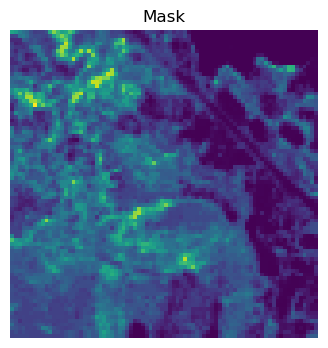

In [8]:
biomass.plot(biomass.__getitem__(tile_bbox));
# dts.__getitem__(bbox)

In [9]:
ee.Initialize()
sentinel = GEESentinel2(year=2018, plevel="toa", tiles=tiles)

In [10]:
sentinel.res

10

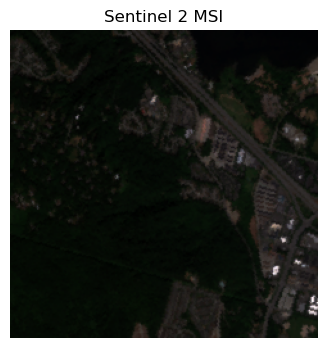

In [11]:
sentinel.plot(sentinel.__getitem__(tile_bbox));

In [12]:
eval(biomass.files.__repr__())

['../data/geodatasets/emapr/biomass/biomassfiaald_2017_median_cog.tif',
 '../data/geodatasets/emapr/biomass/biomassfiaald_2018_median_cog.tif']

In [13]:
landsat8 = GEELandsat8(year=2018, roi=region_bbox)

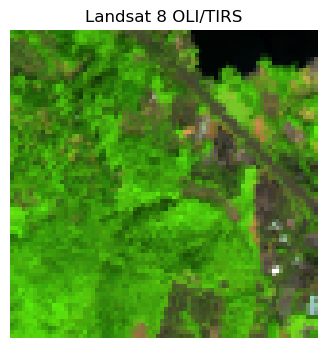

In [14]:
item = landsat8.__getitem__(tile_bbox)
landsat8.plot(item);

In [15]:
# maxx, miny, minx, maxy = tiles.geometry[0].bounds

In [16]:
from sklearn.model_selection import train_test_split


t_tiles, v_tiles = train_test_split(tiles, test_size=0.2, random_state=0)

In [17]:
maxx - minx, maxy - miny

(751200.0, 861600.0)

In [18]:
comb = biomass & landsat8

In [19]:
sampler = PreChippedGeoSampler(comb, shuffle=True)

In [20]:
def check_bbox(bbox):
    minx, maxx, miny, maxy, mint, maxt = bbox
    is_equal = maxx - minx == maxy - miny

    if is_equal is False:
        print(f"bad bbox found (width: {maxx-minx} != height: {maxy-miny})")
        return bbox

In [21]:
# %%
# Suppress rasterio errors while reading geotiffs
# see https://stackoverflow.com/a/74136171/1913361
from osgeo import gdal

gdal.PushErrorHandler("CPLQuietErrorHandler")


0

In [22]:
sentinel = GEESentinel2(year=2018, plevel="toa", roi=region_bbox)

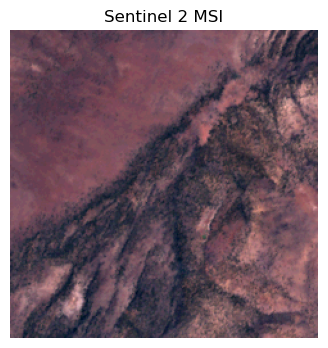

In [23]:
sentinel.plot(sentinel.__getitem__(tile_bbox), contrast=3, brightness=3);

### Load Landsat with custom resolution

In [24]:
l8 = GEELandsat8(year=2018, tiles = tiles, path='.../data/training/landsat8')

torch.Size([7, 80, 80])


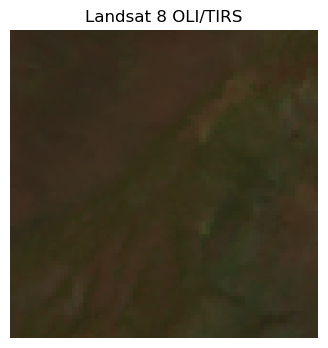

In [25]:
item = l8.__getitem__(tile_bbox)
print(item['image'].shape)
l8.plot(item);

In [26]:
item['image'].shape

torch.Size([7, 80, 80])

In [27]:
[l8.all_bands.index(b) for b in l8.rgb_bands]

[5, 4, 3]

In [28]:
isinstance(l8.bands, list)

True

In [29]:
dw = GEEDynamicWorld(date_start="2018-03-01", date_end="2018-09-30", roi=biomass.bounds, res=30)

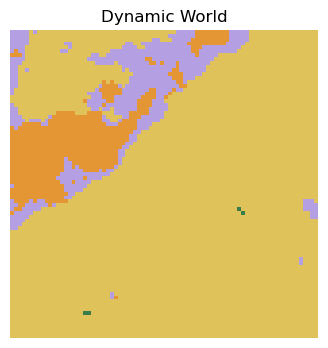

In [30]:
dw.plot(dw.__getitem__(tile_bbox));

In [31]:
agb_mask = biomass & dw & l8

In [32]:
sampler = PreChippedGeoSampler(agb_mask, shuffle=True)

In [33]:
from rasterio.plot import show

In [34]:
ds = DataLoader(agb_mask, sampler=sampler, collate_fn=stack_samples)
for item in ds:
    print(item.keys)
    break

<built-in method keys of collections.defaultdict object at 0x7f6beaf6e2f0>


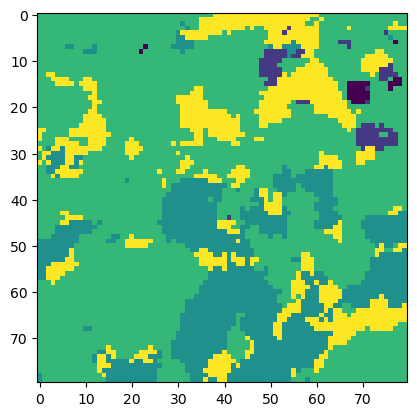

<Axes: >

In [35]:
show(item['mask'].squeeze()[1].numpy())

In [36]:
m = (item['mask'][:,1] == 1) | (item['mask'][:,1] == 5)

torch.Size([1, 80, 80])


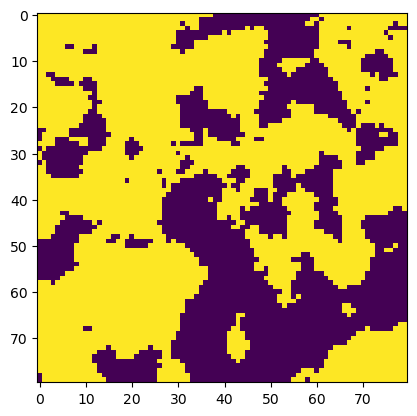

<Axes: >

In [37]:
print(m.shape)
show(m.numpy())

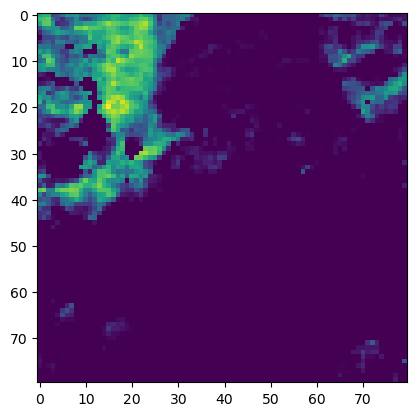

<Axes: >

In [38]:
mask = item['mask'][:,0]
mask[~m] = 0
show(mask.numpy())


In [39]:
mask.unsqueeze(1).shape

torch.Size([1, 1, 80, 80])

In [40]:
dw = GEEDynamicWorld(date_start="2018-03-01", date_end="2018-09-30", tiles=tiles)

In [41]:
tst = dw & l8

In [42]:
ds = DataLoader(tst, sampler=sampler, collate_fn=stack_samples)
for item in ds:
    print(item.keys)
    break

<built-in method keys of collections.defaultdict object at 0x7f6becbffbf0>


In [43]:
item['mask'].shape

torch.Size([1, 1, 240, 240])

In [44]:
item['image'].shape

torch.Size([1, 7, 240, 240])

In [45]:
from forestsegnet2.datasets.sentinel2 import Sentinel2SR
import torch
from torchvision.transforms import v2
from forestsegnet2.datasets import Denormalize

In [75]:
stats = torch.load("../data/geodatasets/sentinel2sr/stats.pth")
mean, std = stats["mean"], stats["std"]
normalize = v2.Compose([v2.Normalize(mean=mean, std=std)])
revert = Denormalize(mean=mean, std=std)


In [76]:
s2 = Sentinel2SR(year=2017, paths="../data/geodatasets/sentinel2sr", transforms=normalize)
s2.files

['../data/geodatasets/sentinel2sr/sentinel2_2017.vrt']

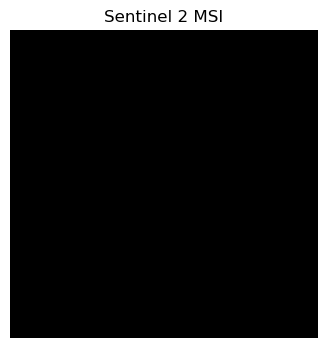

In [77]:
item = s2.__getitem__(tile_bbox)
s2.plot(item, contrast=3, brightness=3, denormalizer=revert);

In [49]:
import torch

img = item['image'][0]
msk = torch.zeros_like(img, dtype=torch.bool)
print(msk.shape, img.shape)
img[~msk].shape

torch.Size([240, 240]) torch.Size([240, 240])


torch.Size([57600])

In [50]:
img = item['image']
img[img == 0]

tensor([])

In [51]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

viridis = mpl.colormaps['viridis'].resampled(8)


In [52]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

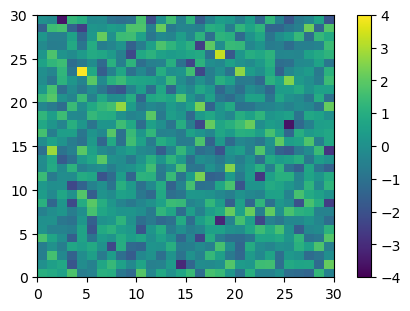

In [53]:
viridis = mpl.colormaps['viridis'].resampled(256)
# newcolors = viridis(np.linspace(0, 1, 256))
# pink = np.array([248/256, 24/256, 148/256, 1])
# newcolors[:25, :] = pink
# newcmp = ListedColormap(newcolors)

plot_examples([viridis])

In [54]:
import torch.nn as nn

In [55]:
m = nn.Dropout(p=0.2)
input = torch.randn(5, 16)
output = m(input)

In [56]:
input#.sum()

tensor([[-0.2142, -1.6219,  2.4133, -0.8673,  1.3278,  1.6077,  0.7274,  0.2658,
         -0.6232, -1.0286, -0.0871,  0.9648,  1.7796, -0.3417, -0.6131, -0.8578],
        [ 0.7703, -0.3091,  0.9254, -0.9243, -0.7942, -0.9090, -0.1419, -2.5874,
          0.0905, -0.8740,  1.3387, -0.0532,  0.6992, -0.8824,  0.4411, -0.9439],
        [ 1.6733,  1.6028,  0.8762, -0.8812,  0.1979, -0.2390,  1.3046, -0.5678,
         -0.2309, -0.5453,  0.7239,  0.8274,  0.5221, -0.7898, -0.3355,  0.5242],
        [ 0.2956, -0.0627,  0.9757,  0.2334, -1.0123, -0.3699,  0.7429,  1.2480,
         -1.2539,  0.1054,  0.2104,  0.7273,  0.7543,  0.5614, -0.9372, -0.6960],
        [ 0.4174,  1.5494,  1.7715,  1.3910,  0.5343, -0.3389,  2.2751, -1.2221,
         -0.6963, -0.8398, -0.8947, -0.7415, -0.1428,  1.0298,  0.8517,  0.2783]])

In [57]:
output#.sum()

tensor([[-0.2678, -0.0000,  3.0166, -1.0842,  1.6598,  0.0000,  0.9092,  0.3323,
         -0.7791, -0.0000, -0.1088,  1.2060,  2.2245, -0.4271, -0.7664, -1.0722],
        [ 0.9629, -0.3863,  1.1567, -1.1554, -0.9927, -0.0000, -0.1774, -0.0000,
          0.1131, -1.0925,  1.6734, -0.0665,  0.8741, -1.1030,  0.5514, -1.1799],
        [ 2.0916,  2.0035,  1.0953, -1.1015,  0.2474, -0.2987,  1.6308, -0.7097,
         -0.2886, -0.6817,  0.9048,  1.0343,  0.6526, -0.9873, -0.0000,  0.6552],
        [ 0.3695, -0.0783,  0.0000,  0.0000, -1.2654, -0.0000,  0.0000,  0.0000,
         -1.5673,  0.1318,  0.2630,  0.0000,  0.9429,  0.0000, -1.1715, -0.8700],
        [ 0.5217,  0.0000,  2.2144,  0.0000,  0.0000, -0.4236,  2.8438, -0.0000,
         -0.8703, -1.0497, -1.1183, -0.9269, -0.1785,  1.2873,  0.0000,  0.0000]])

In [58]:
from forestsegnet2.datasets import GLADForestCanopyHeight, GEEMetaHRGCH

In [59]:
ee.Initialize()

In [60]:
gch = GEEMetaHRGCH(tiles=tiles, res=10)

In [61]:
fch = GLADForestCanopyHeight(tiles=tiles)

torch.Size([1, 80, 80])


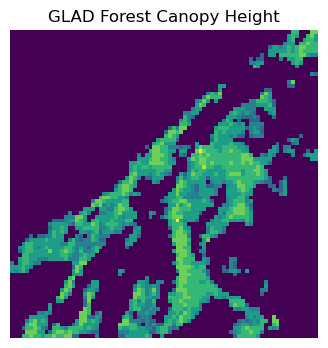

In [62]:
item = fch.__getitem__(tile_bbox)
print(item['mask'].shape)
fch.plot(item);

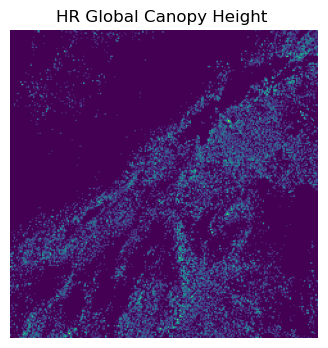

In [63]:
item = gch.__getitem__(tile_bbox)
gch.plot(item);

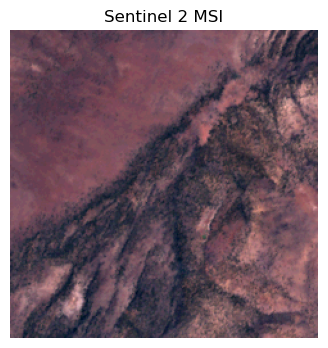

In [64]:
sentinel.plot(sentinel.__getitem__(tile_bbox), contrast=3, brightness=3);

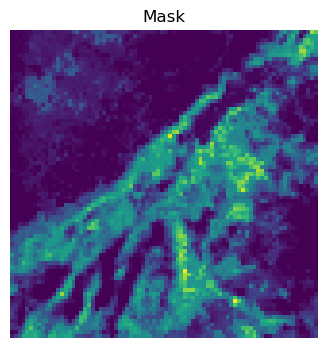

In [65]:
biomass.plot(biomass.__getitem__(tile_bbox));

In [66]:
l8 = GEELandsat8(year=2018, tiles = tiles, path='.../data/training/landsat8')